In [1]:
print("hi")

hi


In [2]:
import torch
import csv
import json
import os
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize 
from tqdm import tqdm
import math


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrmrk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
class RemoveOnIterate:
    def __init__(self, data):
        self.data = data
        self.original_len = len(data)

    def __iter__(self):
        # This method should return the iterator object (in this case, self)
        return self

    def __next__(self):
        # Check if there are more elements in the data
        if self.data:
            # Get and remove the next element from the data
            result = self.data.pop(0)
            return result
        else:
            # No more elements, raise StopIteration
            raise StopIteration
    def __len__(self):
        return self.original_len

In [5]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
base_path = r""
original_cvs_name = r"RecipeNLG_dataset.csv"
prepeard_data_name = "prepeard_data2.csv"
vocab_name = "vocab.csv"


data_name = "data.csv"
data_tokanized_name = "data_tokanized.csv"

count_name = "count.pth"


acum_dist_name = "cumulative_distribution.pth"


data_tensor_name = "data_tensor.pth"
data_tensor_len_name = "data_len_tensor.pth"

In [7]:
"""with open(base_path + original_cvs_name, 'r', newline='', encoding='utf-8') as input_csvfile:
    for data_len,row in enumerate(csv.reader(input_csvfile)):
        pass"""
data_len = 2231142
data_len

2231142

In [8]:
bads = ['\x00']

def fix_text(line, j):
    return j.join([r for r in json.loads(line) if not all([r.__contains__(bad) for bad in bads])])
if not os.path.exists(base_path + data_name):
    with open(base_path + original_cvs_name, 'r', newline='', encoding='utf-8') as input_csvfile:
        with open(base_path + data_name, 'w', newline='', encoding='utf-8') as output_csvfile:
            csv_writer = csv.writer(output_csvfile)
            csv_reader = csv.reader(input_csvfile)
            next(csv_reader, None)

            # Copy selected columns from the input file to the output file
            for row in (tqdm(csv_reader)):
                row = [fix_text(row[2], " * "),fix_text(row[3], " ")]
                csv_writer.writerow(row)
                


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KG\\Documents\\GitHub\\recipe_generation\\\\RecipeNLG_dataset.csv'

In [ ]:

if not os.path.exists(base_path + data_tokanized_name):
    with open(base_path + data_name, 'r', newline='', encoding='utf-8') as input_csvfile:
        with open(base_path + data_tokanized_name, 'w', newline='', encoding='utf-8') as output_csvfile:
            csv_writer = csv.writer(output_csvfile)
            csv_reader = csv.reader(input_csvfile)
        
            for (ingrent_list, recipie) in tqdm(csv_reader, total=data_len):
                ingrent_tokalized = [w.lower() for w in word_tokenize(ingrent_list)]
                recipie_tokalized = [w.lower() for w in word_tokenize(recipie)]
                csv_writer.writerow((ingrent_tokalized, recipie_tokalized))

In [11]:
if not os.path.exists(base_path + count_name):
    count = Counter()


    with open(base_path + data_tokanized_name, 'r', newline='', encoding='utf-8') as input_csvfile:
        csv_reader = csv.reader(input_csvfile)
        for ingrent_tokalized, recipie_tokalized in tqdm(csv_reader, total=data_len):
            for word in eval(ingrent_tokalized):
                count[word] += 1
            for word in eval(recipie_tokalized):
                count[word] += 1
    torch.save(count, base_path + count_name)
    
count = torch.load(base_path + count_name)


In [13]:
print(count.most_common(20))

[('.', 21855751), ('*', 17348785), (',', 15009262), ('and', 10618867), ('the', 8904360), ('1', 8468765), ('to', 5503526), ('in', 5352003), ('a', 4986816), ('2', 4161585), ('with', 3440550), ('1/2', 3306458), (')', 3206781), ('(', 3192694), ('of', 2962607), ('cup', 2943471), ('until', 2900352), ('add', 2742097), ('for', 2595950), ('or', 2576990)]


In [14]:
if not os.path.exists(base_path + acum_dist_name):
    acum_dist = []
    suum = 0
    s = sum(count.values())
    for w, c in count.most_common():
        suum += c
        acum_dist.append(suum / s)
    
  
    torch.save(acum_dist, base_path + acum_dist_name)

acum_dist = torch.load(base_path + acum_dist_name)

print(acum_dist[:10])

[0.06290745189193798, 0.11284249451623743, 0.15604368340233396, 0.18660798956364535, 0.21223742679179172, 0.2366130900587107, 0.25245389997098644, 0.2678585809287814, 0.2822121434128135, 0.29419044185617105]


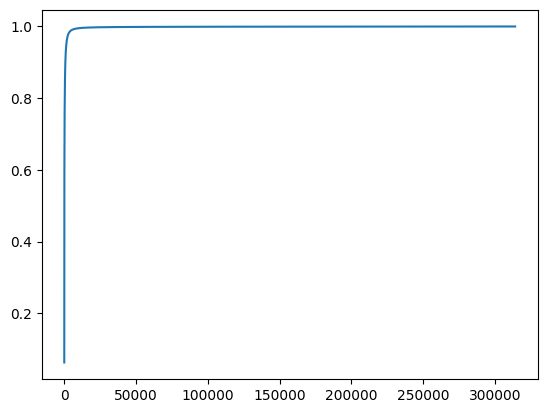

In [15]:
import matplotlib.pyplot as plt

# Your list of values

# Plotting the list
plt.plot(acum_dist)

# Display the plot
plt.show()


In [ ]:
def find_index_larger_than(lst, x):
    for i, item in enumerate(lst):
        if item > x:
            return i
    return -1  # If no item is larger than x

In [ ]:
ing_sum = sum(count.values())
print(len(count))
prob = 0.95318
words = ["<UKN>", "<PAD>"] + [t[0] for t in count.most_common(find_index_larger_than(acum_dist, prob))]
print(len(words))
print(count[words[-1]])
words[-1]

314174
1500
12729


'crusty'

In [ ]:
word_to_id = dict(zip(words, list(range(len(words)))))

if not os.path.exists(base_path + prepeard_data_name):
    with open(base_path + prepeard_data_name, 'w', newline='', encoding='utf-8') as output_csvfile:
        with open(base_path + data_tokanized_name, 'r', newline='', encoding='utf-8') as input_csvfile:
            csv_reader = csv.reader(input_csvfile)
            csv_writer = csv.writer(output_csvfile)
            a = next(csv_reader)
            csv_writer.writerow(["X","Y"])

            for ing, rec in tqdm(csv_reader, total=data_len):
                ing_ids = [word_to_id.get(i,0) for i in eval(ing)]
                rec_ids = [word_to_id.get(r,0) for r in eval(rec)]
                csv_writer.writerow((ing_ids, rec_ids))

100%|█████████▉| 2231141/2231142 [09:21<00:00, 3976.76it/s]


In [ ]:
"""with open(base_path + prepeard_data_name, 'r') as file:
        next(csv.reader(file))
        maax_len = 0
        for i, (ing, rec) in enumerate(tqdm(csv.reader(file), total=data_len)):
            l = max(len(eval(ing)), len(eval(rec)))
            if l > maax_len:
                maax_len = l"""
maax_len = 3016

In [ ]:

with open(base_path + vocab_name, 'w', newline='', encoding='utf-8') as output_csvfile:
    csv_writer = csv.writer(output_csvfile)

    csv_writer.writerow(["words"])

    # Copy selected columns from the input file to the output file
    for row in words:
        csv_writer.writerow([row])